# Homework 7: Advanced Regression

In [1]:
rm(list=ls())

In [2]:
# Question 10.1a - Tree Model
if (!require("tree")) install.packages("tree") 
if (!require("randomForest")) install.packages("randomForest") 

Loading required package: tree
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


## Question 10.1

We begin by reading in the data and preparing for model validation later on. Some of the recurring themes in homeworks, as will be in most regression, is calculating the R-Squared value and an error/accuracy metric which will be the Root Mean Squared Error (RMSE) for us here.
  
Since we want the models to be evaluted on a fair basis, we will set the seed so that they are trained and then tested on the same data samples.

In [3]:
# US Crime data
uscrime <- read.table('uscrime.txt', stringsAsFactors=FALSE, header=TRUE)

In [4]:
# Use in model validation later on
set.seed(42)
sample <- round(sample(nrow(uscrime)*0.7))
train <- uscrime[sample,]
test <- uscrime[-sample,]

In [5]:
get_r2 <- function(yhat, y){
    
    SSres <- sum((yhat-y)^2)
    SStot <- sum((y-mean(y))^2)
    R2 <- 1-SSres/SStot
    return(R2)
}

In [6]:
get_rmse <- function(a, b) {
    
    rmse <- sqrt(mean((a -b)^2))
    return(rmse)
}

### a.) Regression Tree Model

__Basic Tree Model__

In [7]:
# Build basic tree model
library(tree)
model.tree <- tree(Crime~.,
                data=uscrime)

In [8]:
# Summarize
summary(model.tree)


Regression tree:
tree(formula = Crime ~ ., data = uscrime)
Variables actually used in tree construction:
[1] "Po1" "Pop" "LF"  "NW" 
Number of terminal nodes:  7 
Residual mean deviance:  47390 = 1896000 / 40 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-573.900  -98.300   -1.545    0.000  110.600  490.100 

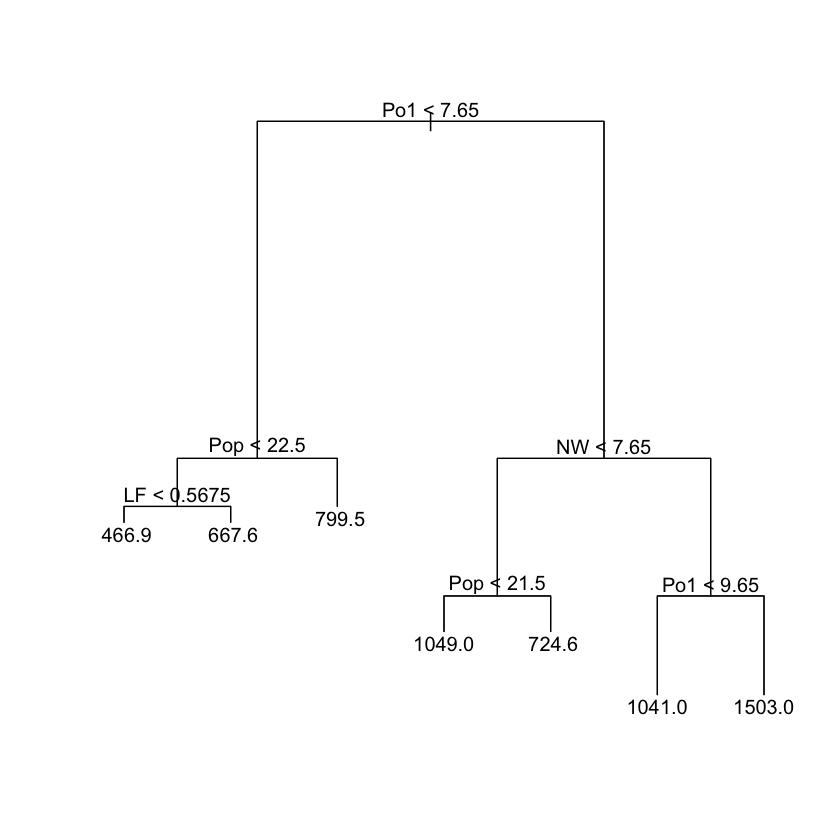

In [9]:
# Visualize the branches and leaves made by the model
plot(model.tree)
text(model.tree)

The terminal nodes refer to leaves.  
The distribution of residuals is looking fairly Normal, which is good since heavy skews indicate we have some sort of prediction bias.
  
The residual mean deviance is probably one of the most important ones to note from here. The deviance is basically like the sum of squared errors in linear regression. There is obviously a lot of error here. 

In [10]:
tree.pred <- predict(model.tree)
tree.y <- uscrime$Crime
get_r2(tree.pred, tree.y)

[1] 0.7244962

This is our regression model's R^2 value. As always, our basic tree model accounts for abbout 72% of variance in our data. We will be using this to compare to our other models as we move on.

__Pruned Tree Model__

In [11]:
# Build a pruned tree model
model.prune <- prune.tree(model.tree, best=4)

In [12]:
summary(model.prune)


Regression tree:
snip.tree(tree = model.tree, nodes = c(6L, 2L))
Variables actually used in tree construction:
[1] "Po1" "NW" 
Number of terminal nodes:  4 
Residual mean deviance:  61220 = 2633000 / 43 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-573.90 -152.60   35.39    0.00  158.90  490.10 

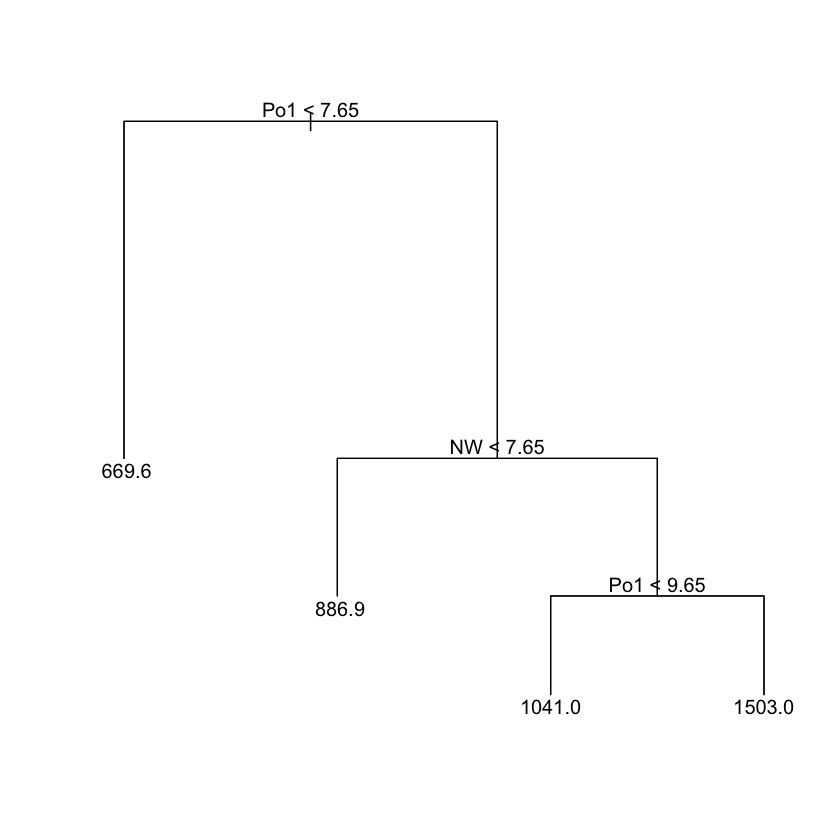

In [13]:
plot(model.prune)
text(model.prune)

In [14]:
prune.pred <- predict(model.prune)

In [15]:
get_r2(prune.pred, uscrime$Crime)

[1] 0.6174017

The analysis here is pretty much the exact same. We now have a pruned tree model with 4 leaves using only 2 predictors (as opposed to 7 leaves with 4 predictors.  
We set "best = 4" in the model hyperparameters to dictate the number of leaves, which ended up leaving 2 predictors. Notice that that these are the same leaves and branches of the basic tree model. All we did was apply the prune method to our model, which cut off some branches as we might literally do so from a physical tree.
  
The R^2 value went down to ~0.62, so as expected and is the point, our model is less fitted to the data.  
Another way to have known this is just by looking at the deviance. The final deviance is just the sum of residuals squared, SSres divided by n.

__Model Validation__

In [16]:
# Validate models
b <- test$Crime
a.tree <- predict(model.tree, test[,1:15])
a.prune <- predict(model.prune, test[,1:15])

get_rmse(a.tree, b)
get_rmse(a.prune, b)

[1] 163.4527

[1] 221.3876

In [17]:
# Build new models without overlapping train and test sets
model.tree2 <- tree(Crime~.,
                    data = train)
model.prune2 <- prune.tree(model.tree2, best=4)

# Predict using new models
b <- test$Crime
a.tree <- predict(model.tree2, test[,1:15])
a.prune <- predict(model.prune2, test[,1:15])

# Validation scores
tree.rmse <- get_rmse(a.tree, b)
prune.rmse <- get_rmse(a.prune, b)

tree.rmse
prune.rmse

[1] 477.8731

[1] 468.5978

We try this twice - once with the models we analyzed earlier, and again with new models using our actual training data. The difference is that our first set of models were tested using the data we trained with, so they get relatively excellent rmse values. When we do it again without data overlap, we see how much worse they fare.
  
While the difference is not staggeringly high, notice the differences:
1. rmse basic tree > rmse prune tree  
2. rmse bbasic tree < rmse prune tree  
  
As we noted before, pruning a model simplifies and regularizes the model to fit less exactly to the training data. In the case where the testing data was a part of the training data, overfitting the model led to a better testing score than when we pruned.  
On the other hand, when we simplify the model we actually help avoid overfitting and now the model is more generalizable to new data.

In [18]:
# R^2 values for the validated models
tree2.pred <- predict(model.tree2)
prune2.pred <- predict(model.prune2)

get_r2(tree2.pred, train$Crime)
get_r2(prune2.pred, train$Crime)

[1] 0.7990706

[1] 0.7630405

Indeed, the basic tree model has a better R^2 value than the pruned model but still predicted worse.  
  
As I will note again in the randomForest example, it is still important to remember that we did not perform any significance testing. So while the logic for these concepts remain, there is still a reasonable probability that all of this is only happened due to random chance because of the small sample size.

### b.) Random Forest Regression

In [19]:
library(randomForest)

In [20]:
# Build Random Forest model
num_tree <- c(500, 1000, 1500)
num_pred <- c(3, 4, 5, 6, 7)

set.seed(42)
# Loop though number of trees
for (j in num_tree) {
    # Loop through number of predictors
    for (i in num_pred) {
        rf <- randomForest(Crime~.,
                       data = train,
                       importance=TRUE,
                       mtry = i,
                       ntree=j)
        # Calcualte R^2 since printing summary takes up a lot of space
        yhat <- predict(rf)
        y <- train$Crime
        r2 <- get_r2(yhat, y)

        # Test model on our validation set
        rf.pred <- predict(rf, test[,1:15])
        rf.y <- test$Crime
        rmse <- sqrt(mean((rf.pred - rf.y)^2))
        
        # Print results
        p <- c(r2, rmse, j, i)
        print(p)
    }
}

[1]   0.4788978 233.4087532 500.0000000   3.0000000
[1]   0.445806 245.342885 500.000000   4.000000
[1]   0.4404742 243.0682014 500.0000000   5.0000000
[1]   0.4414786 249.5693498 500.0000000   6.0000000
[1]   0.4398327 253.6209849 500.0000000   7.0000000
[1]    0.4615483  238.1595028 1000.0000000    3.0000000
[1]    0.4550624  237.0147909 1000.0000000    4.0000000
[1]    0.448169  247.530035 1000.000000    5.000000
[1]    0.4461728  250.6853435 1000.0000000    6.0000000
[1]    0.4589873  259.4010015 1000.0000000    7.0000000
[1]    0.4600747  228.4386849 1500.0000000    3.0000000
[1]    0.4707548  238.0765984 1500.0000000    4.0000000
[1]    0.457173  244.816022 1500.000000    5.000000
[1]    0.4498236  251.3113523 1500.0000000    6.0000000
[1]    0.454231  255.983061 1500.000000    7.000000


__Analyze Model__  
What is cool here is that the model with the best validation score also does not have the least or greatest R^2 value. We can interpret this to mean that while the model is not as relatively overfit, it also is very representative of the data and generalizable AKA useful. Again, it is important to note that with a sample size this small, this is easily an insignificant different in rmse and R^2 values.  
Sure enough, when I did not set seed and ran my code several times while constructing this assignment, I got different results.
  
__Compare Model__  
While I just mentioned how we did not test for significance between model validation scores, just looking at the overall scores of the random forest models show a huge difference between the tree and pruned tree models. These random forest models have a lower R^2 but even better rmse scores. Clearly, the basic tree and pruned tree models were overfitting.

__Interpret Model (Random Forest)__

In [21]:
# New random forest using validated parameters
set.seed(40)
rf <- randomForest(Crime~.,
                   data=train,
                   mtry=3,
                   ntree=1500,
                   importance=TRUE)

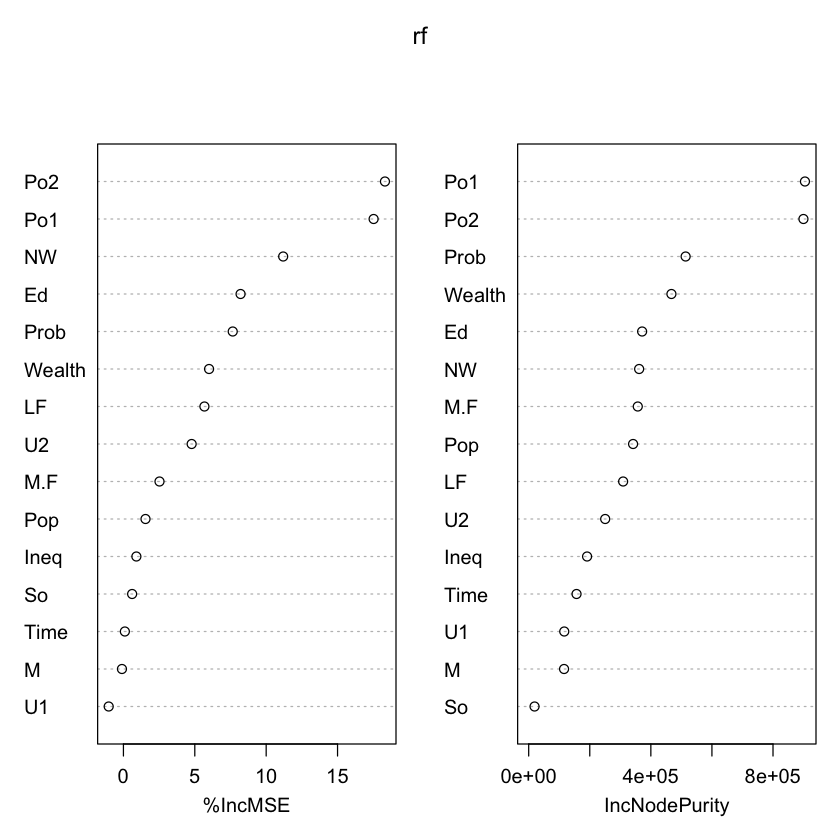

In [22]:
# Importance Plot
varImpPlot(rf)

Having a higher %IncMSE means that the predictor is better. Similar to analyzing coefficients from linear regression, we can take this to mean that Po1 and Po2 were more important to the random forests than were the other features. We can look at the magnitude relative to another as well, and see that there is another jump in important from using the first 8 predictors over the last 7. 
  
We can see how Po1, NW, and LF were all important to both the random forest and to the basic tree model.

## Question 10.2

Logistic Regression can be useful in predicting whether or not government will shut down due to weather.
  
The predictors for this can be fairly simple - chance of snow (obtained by various manipulations such as the average across each hourly prediction), the minimum temperature or temperature as certain times of day, the number of historical snow days for the season, and even the day of week.
  
Since logistic regression gives a probability output, we can split up the probability thresholds to account for delays in government opening. A better way, however, would be to apply Multinomial logistic regression techniques. An example is in predicting whether the government will be open OR (closed or delay). Then, we can use another model to determine a split between closing and delaying.

## Question 10.3

Here we will take similar steps as with the tree, prune, and random forest regressors but this time with Logistic Regression. Note that our model will now be evaluated differently since we are classifying not regressing (?). So "close" answers don't exist - instead, they are either right or wrong. 
  
Of course, deeper analytics can show us what probability the logistic regression predicted with to support a 0 or 1 decision, but that is too much for now.

In [23]:
gc <- read.table('germancredit.txt', sep=' ')

In [24]:
# Split target variable into 0, 1 binary
gc$V21 <- gc$V21 -1

In [25]:
head(gc)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
A11,6,A34,A43,1169,A65,A75,4,A93,A101,⋯,A121,67,A143,A152,2,A173,1,A192,A201,0
A12,48,A32,A43,5951,A61,A73,2,A92,A101,⋯,A121,22,A143,A152,1,A173,1,A191,A201,1
A14,12,A34,A46,2096,A61,A74,2,A93,A101,⋯,A121,49,A143,A152,1,A172,2,A191,A201,0
A11,42,A32,A42,7882,A61,A74,2,A93,A103,⋯,A122,45,A143,A153,1,A173,2,A191,A201,0
A11,24,A33,A40,4870,A61,A73,3,A93,A101,⋯,A124,53,A143,A153,2,A173,2,A191,A201,1
A14,36,A32,A46,9055,A65,A73,2,A93,A101,⋯,A124,35,A143,A153,1,A172,2,A192,A201,0


In [26]:
# Use in model validation later on
set.seed(42)

sample <- sample(nrow(gc)*0.8)
train <- gc[sample,]
test <- gc[-sample,]

head(gc)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
A11,6,A34,A43,1169,A65,A75,4,A93,A101,⋯,A121,67,A143,A152,2,A173,1,A192,A201,0
A12,48,A32,A43,5951,A61,A73,2,A92,A101,⋯,A121,22,A143,A152,1,A173,1,A191,A201,1
A14,12,A34,A46,2096,A61,A74,2,A93,A101,⋯,A121,49,A143,A152,1,A172,2,A191,A201,0
A11,42,A32,A42,7882,A61,A74,2,A93,A103,⋯,A122,45,A143,A153,1,A173,2,A191,A201,0
A11,24,A33,A40,4870,A61,A73,3,A93,A101,⋯,A124,53,A143,A153,2,A173,2,A191,A201,1
A14,36,A32,A46,9055,A65,A73,2,A93,A101,⋯,A124,35,A143,A153,1,A172,2,A192,A201,0


In [27]:
# Build logistic regression model
model.log <- glm(V21~.,
                 family=binomial(link = 'logit'),
                 data=train)

In [28]:
# Summary
summary(model.log)


Call:
glm(formula = V21 ~ ., family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7373  -0.6979  -0.3604   0.6663   2.5591  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.978e-01  1.249e+00   0.318 0.750139    
V1A12       -2.701e-01  2.437e-01  -1.108 0.267784    
V1A13       -9.306e-01  4.018e-01  -2.316 0.020567 *  
V1A14       -1.737e+00  2.686e-01  -6.465 1.02e-10 ***
V2           2.893e-02  1.042e-02   2.777 0.005479 ** 
V3A31        2.255e-01  6.289e-01   0.359 0.719936    
V3A32       -7.639e-01  4.753e-01  -1.607 0.108022    
V3A33       -9.172e-01  5.233e-01  -1.753 0.079627 .  
V3A34       -1.487e+00  4.907e-01  -3.031 0.002440 ** 
V4A41       -1.832e+00  4.425e-01  -4.141 3.46e-05 ***
V4A410      -1.413e+00  8.263e-01  -1.710 0.087326 .  
V4A42       -9.368e-01  2.990e-01  -3.134 0.001727 ** 
V4A43       -9.044e-01  2.799e-01  -3.230 0.001236 ** 
V4A44       -8.312e-01

In [29]:
# Build logistic regression model again with significant features
# Exactly what the office hour TA did but since we are using a smaller sample, have slighlty different results
model.log2 <- glm(V21~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V9 + +V10 + V13,
                 family=binomial(link = 'logit'),
                 data=train)

In [30]:
summary(model.log2)


Call:
glm(formula = V21 ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V9 + +V10 + 
    V13, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5768  -0.7208  -0.4013   0.7474   2.6162  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.275e+00  8.367e-01   2.719  0.00655 ** 
V1A12       -2.999e-01  2.310e-01  -1.298  0.19417    
V1A13       -1.058e+00  3.857e-01  -2.743  0.00608 ** 
V1A14       -1.734e+00  2.579e-01  -6.725 1.76e-11 ***
V2           4.022e-02  9.566e-03   4.204 2.62e-05 ***
V3A31        2.303e-01  5.696e-01   0.404  0.68603    
V3A32       -9.812e-01  4.352e-01  -2.255  0.02416 *  
V3A33       -9.537e-01  5.003e-01  -1.906  0.05662 .  
V3A34       -1.492e+00  4.624e-01  -3.227  0.00125 ** 
V4A41       -1.640e+00  4.123e-01  -3.978 6.95e-05 ***
V4A410      -1.264e+00  7.814e-01  -1.617  0.10587    
V4A42       -8.686e-01  2.822e-01  -3.078  0.00208 ** 
V4A43       -8.519e-01 

The AIC and deviance scores are higher in this one, albeit slightly, but that should be okay since we have made the model more robust.  
So, we have our model that we will be using to make predictions on!

__MODEL THRESHOLD__

We must take into account how classifying bad customer as good is 5x worse than misjudging a good customer as bad.  
Basically, false positives are much worse than false negatives. This is the opposite to the spam email where it is not okay to judge good emails as bad. 
  
What does this mean mathematically?  
We want the threshold to be higher than 0.5 in the 0 to 1 scale. In a perfectly neutral example, we would leave the threshold at 0.5 and anything equal or higher gets a 0 (good) and lower gets a 1 (bad). 
  
Using true/false positive/negatives with TP, TN, FP, FN and looking at cost function C:  
C(FP) = 5   
C(FN) = 1  
C(TP) = C(TN) = 0 #correct classifications

In [31]:
# From TA Office Hours
# 1 means bad, 0 means good in this case
C = function(r, pi, threshold) {
    
    # Bad Customer
    if (r==1) { 
       if (pi < threshold) { #predicted as good customer
          return(5)
       }
       else {
          return(0) #true negative
            }
       }
    
    # Good Customer
    if (r==0) {
        if (pi > threshold) { #predicted as bad customer
            return(1)
        }
        else {
            return(0) #true positive
        }
    }
}

In [32]:
# Data rows
log2.pred <- predict(model.log2, type='response')
ans <- train$V21
iter <- 1:length(log2.pred)

# Thresholds to try
T <- 1:100
cost <- vector()

# Loop and store total costs into a vector for each threshold
for (t in T) {
    
    x <- vector()
    for (i in iter) {
        c <- C(ans[i], log2.pred[i], t/100)
        x[i] <- c
    }
    cost[t] <- sum(x)
}

In [33]:
index <- which(cost==min(cost))
threshold <- T[index]/100
cost[index]
threshold

[1] 383

[1] 0.15

It looks like the threshold with the least cost is 0.15. We can thus build our predictions using this to our knowledge. This makes sense since our cost of FP and FN is a 5:1 ratio - it isn't exact, but that is probably because of the distribution of data being not exact either.

__MODEL ANALYSIS__

In [34]:
# Convert predictions into values
yhat <- log2.pred
yhat[yhat > threshold] <- 1
yhat[yhat < threshold] <- 0

In [35]:
# Compare fit with training data
get_r2(log2.pred, ans)
get_rmse(log2.pred, ans)

[1] 0.2834816

[1] 0.3874397

If we had judged this as a linear regression model, we would have accounted for very little variance in the data and had a pretty harsh rmse score - after all, we are judging on a 0 to 1 scale. However, since we did this based off of classification algorithm and are judging with the cost criteria, let's us look at a matrix.

In [36]:
# Truth Table
table(yhat, ans)

    ans
yhat   0   1
   0 283  21
   1 278 218

We got ~63% correct. More importantly, as we had calculated, 278(1) + 21(5) = 383. Let us see how our model actually does with our testing set. Hopefully the cost will not be much worse than this, or else we know that we overfit the model.

__MODEL VALIDATION__

In [37]:
# Predict on test set
# V1 + V2 + V3 + V4 + V5 + V6 + V7 + V9 + +V10 + V13
predictors <- c(1,2,3,4,5,6,7,9,10,13)
log2.pred.test <- predict(model.log2, test[,predictors], type='response')

In [38]:
# Convert to test answers to binary
yhat.test <- log2.pred.test
yhat.test[yhat.test > threshold] <- 1
yhat.test[yhat.test < threshold] <- 0

In [39]:
# Truth Table on Testing Predictions
table(yhat.test, test[,21])

         
yhat.test  0  1
        0 70  4
        1 69 57

In [40]:
# TEST
table(test[,21])


  0   1 
139  61 

In [41]:
# TRAIN
table(train[,21])


  0   1 
561 239 

We see that the training and testing sets were sampled well since they have very similar proportions of 0 and 1 counts to one another. Furthermore, we got abobut ~64% of the predictions correct to a total cost of C = 89. This is 23% of the training evaluation cost, which is good considering that the testing:training sets have a 2:8 ratio. 